# Tokenization in LLMs 

- it is necessary to understand in some detail, a lot of oddness in LLMs typically traces back to tokenization

- what is tokenization?
    - our dataset is text, and we can't just feed it to the model as it is, we need to convert it to a format that the model can understand (numbers)
    - so far we did a very naive tokenization, that is on the character level, so our vocabulary mapped each character to a unique number
        - then we used an embedding table to convert them into unique vectors (now each character is represented by a vector/embedding)
        - in other words, we used the integer as a lookup key to get the corresponding row, to get the embedding vector that feeds into the transformer
        - these embeddings are trainable, so the model learns to represent and group the characters together in the embedding space based on the context (similar characters are closer to each other in the embedding space)

    - in practice, we said that people use a lot more complicated schemes for constructing these token vocabularies
        - we will be dealing on a chunk level -mine: subword level-, and algorithms such as BPE (Byte Pair Encoding) are used to construct the vocabulary

    - the paper [Language models are unsupervised multitask learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) introduced byte level encoding as a method of tokenization in the context of LLMs (it is the GPT-2 Paper)
        - in the paper, the vocabulary has 50,257 tokens, and the context size is 1024 tokens
            - so in the attention layer of the transformer, the tokens can see up to 1024 tokens back in the sequence (mine: the last token will see the  1023 tokens before it and itself)

    - we will build our own tokenizer. Luckily, Byte pair encoding is not super complicated, and we can build it from scratch


## Motivation
- Why we need good tokenization? 
    - tokenization is at the heart of a lot of weirdness in LLMs, so don't brush it off
        - in other words, a lot of the issues that may look like just issues with the architecture or the LLM itself, are actually issues with tokenization
    - examples on these issues: 
    - why can't LLM spell words? `Tokenization`
    - why can't LLM do super simple string processing tasks like reversing a string? `Tokenization`
    - why is LLM worse at non-english languages? `Tokenization`
    - why is LLM bad at simple arithmetic? `Tokenization`
    - why did GPT-2 have more than necessary trouble coding in python? `Tokenization`
    - why did my LLM abrubtly halt when it sees the string `<endoftext>`? `Tokenization`
    - what is this weird warning i get about a "trailing whitespace"? `Tokenization`
    - why the LLM break if I ask it about "SolidGoldMagikarp"? `Tokenization`
    - why should I prefer to use YAML over JSON with LLMs? `Tokenization`
    - why is LLM not actually end-to-end Language modeling? `Tokenization`
    - what is the real root of suffering? `Tokenization` :D

- so tokenization is at the heart of many issues, all the above issues can be traced to a large extent to tokenization
- good tokenization webApp, the [tiktokenizer](https://tiktokenizer.vercel.app/) 
    - what is good about it is that tokenization is running live in the browser

![image.png](assets/gpt2_tokenizer_example.png)

- for the english sentence
    - we see the word "tokenization" is broken down into 2 tokens: `token` and `ization`
    - the token ' is' is a -space is- single token 
    - the token ' at' -space+at- is a single token
    - the token ' the' -space+the- is a single token
    - so notice that the space is part of the token chunk

- as for the arithmetic example
    - 127 is a token,  'space +' is a token, 'space 6' is a token, and the rest of the number '77' is a token
    - it is all completely arbitrary (sometimes we have multiple digits in a single token, and sometimes we have individual digits as separate tokens)

- we also see that Egg by itself at the beginning of the sentence is 2 tokens, and space+Egg is a single token
- lowercase egg is a single token :D (a different token, so it is case sensitive)
- EGG (all capital) is also a different token (2 tokens arbitrarily)
    - so for the same word, depending on if it's at the beginning of the sentence or not, and depending on upper/lower/mixed case, we have different tokens (different identities)
    - and the LLM has to learn from raw data -from all the internet text that it's going to be training on- that these are actually all the same word, and the differences are very small -it has to group these identities together in the embedding space-


- in korean, we see why non-english languages work slightly worse in ChatGPT
    - we will notice that non-english languages work slightly worse in chatGPT, part of that is because the training dataset for chatGPT is much larger for English than for other languages, but the same is true for the tokenizer!
        - we will see that we will train the tokenizer, and that there is a training set for it as well, and there is a lot more english than non-english
        - what ends up happening is that we are going to have a lot more longer tokens for english than non-english (mine: the english tokens span more characters than the non-english tokens)
            - mine: notice above that the korean sentence is almost tokenized character by character
            - so if we have a single sentence in English and we tokenize it, it will be only 10 tokens for example, but if we tokenize the same sentence in other languages, it will be much more tokens (the token in other languages span fewer characters, in other words the chunks are much more broken up into several tokens)
            - so we are using a lot more tokens for the exact same thing
            - and what this does is bloating up the sequence length (mine: we already talked about when the tokens span fewer characters -like character level tokenization- the sequence length will be much longer)
                - and in the attention, if the sentence span a lot of tokens, fewer sentences will fit into the context window, so we are running out of context
                    - unlike english, where the sentence is small number of tokens, the transformer will see more context before predicting the next token
        - mine: to summarize, the context in english span few tokens, so the transformer -which fits 1024 tokens into its context, allowing them to attend and communicate with each other in the self-attention- will fit a lot more sentences, so it is easier to capture long range dependencies in english. As for non-english languages, the same number of tokens -1024- will span fewer characters, so what will fit into the self-attention context is much less
           

- the final example we have is python snippet

    ![image-2.png](assets/gpt2_python_tokenization.png)

    - notice that all individual spaces are all separate tokens, token 220
        - so 220 220 220 space+if 
        - so when the transformer consumes or generates this text, it needs to handle all these spaces individually (all spaces feed in one by one)
            - so it is extremely wasteful tokenizing it this way
        - that is why GPT-2 is not good with Python, it has nothing to do with coding or the language model itself, it is just that we are wasting a lot of the context size with space tokens (we are bloating out the code on way too many sequence to fit into the context window)



- mine: notice how it is important to fit as many information as possible in the context length, since it takes fixed number of tokens, the only way to do that is for the token to span longer chunks of text, so we can fit more information in the context window, so the transformer can learn better from the context
    - that is because of the attention mechanism in the context window, all tokens attend and communicate with each other, so it is like the transformer's ready and immediate memory


- so the above example's information was spanned in 300 tokens in GPT-2 tokenizer, let's see what GPT-4 tokenizer will do (the tokenizer for GPT4 is called cl100k_base)

![image-3.png](assets/gpt4_tokenizer.png)

- we see that the count drops to 185 (we used fewer tokens to represent the same information)
    - that is because the tokenizer spans longer chunks of text
    - remember that we said when the tokenizer span longer chunks of text, we have a lot more tokens (becase we need fewer tokens to represent small information -like character level tokenization- and we need more tokens to represent larger information)
        - and indeed the vocabulary size in the GPT-4 tokenizer is roughly double that of GPT-2 tokenizer (we went from 50k to 100k tokens)
        - that is a good thing, because the same text is squishd into half as many tokens, so we can fit more information into the context window (we are roughly able to see twice as much text as a context for what token to predict next)

- however, just increasing the number of tokens is not strictly better infinitely 
    - because as we increase the number of tokens, now our embedding table is getting a lot larger, and at the output where we are trying to predict the next token out of all possible tokens grows as well
    - so there is a sweet spot in the middle (just right) regarding the vocabulary size where the information is appropriately densed and still fairly efficient

- notice the handling of the white space in the GPT-4 tokenizer, all the spaces in python are represented as a single token 
    - 3 spaces as single token then space+if as a single token
    - 7 spaces as a single token
    - this was deliberate by openAI when they designed the gpt-4 tokenizer
        - grouping a lot more whitespace into a single character densifies python code and therefore, we can attend to more code before it when we try to predict the next token in the sequence 
        - so the improvment in python coding ability from GPT-2 to GPT-4 is not just a matter of the architecture and details of the opitmization, but also from the design of the tokenizer and how it groups characters into tokens

- what makes this tricky is that we want to tokenize not just english text, we want to support different languages and also special characters (like emojis)

## Text representation in computers

In [1]:
text = "안녕하세요 👋 (Hello in English!)"
text

'안녕하세요 👋 (Hello in English!)'

- how is this text represented in python in the first place?
    - textual data in python is handled with `str` objects, strings are immutable sequences of unicode code points

- mine: historical overview
    - people first represented text in computers using ASCII, which represented the english characters and some symbols in integers from 0 to 255 (1 byte)
        - so each character is represented by a single byte
    - then people wanted to represent more characters, so they came up with unicode, which is a standard that defines a lot more characters and symbols
        - for each character, there is a unique integer representation (unicode code point)
            -  These code points for range from 0 to 0x10FFFF (1,114,112 decimal), but not all numbers are assigned to characters yet (currently, there are around 150k characters defined)
            - so the maximum hex number is 1,114,112, which is represented by 21 bits, which primarily needs 3 bytes (24 bits) to represent any unicode character
            - but due to some alignment issues (the architecture of the computer), it is more efficient to represent the unicode characters in 4 bytes (32 bits)
        - but using 4 bytes to represent each character -that is called UTF-32- is very inefficient, because most of the characters are in the lower range -like the english characters- and they can be represented by 1 byte
        - UTF-8 is a variable-length encoding, where characters can be 1 to 4 bytes long. This allows for efficient encoding of common characters (like those in ASCII) while still being able to represent every Unicode character.
            - For example, the character 'A' in UTF-8 is represented as 0x41 (1 byte), just like in ASCII. But a less common character, like '😊', is represented as 0xF0 0x9F 0x98 0x8A (4 bytes).
        - This variable-length nature of UTF-8 allows it to be both space-efficient and capable of representing all Unicode characters.
        - UTF-16 is another variable-length encoding, but it uses 2 or 4 bytes per character. UTF-32, on the other hand, uses a fixed 4 bytes per character as we said



- the way we can access the unicode code point (integer representation) of a character in python is by using the `ord` function

In [2]:
ord('h'), ord('👋'), ord('ي')

(104, 128075, 1610)

In [3]:
try:
    ord("hello")
except TypeError as e:
    print(e)

ord() expected a character, but string of length 5 found


- notice that the unicode code points are defined for each character not for multiple characters at once

In [4]:
[ord(c) for c in text]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 72,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 69,
 110,
 103,
 108,
 105,
 115,
 104,
 33,
 41]

In [5]:
max([ord(c) for c in text])

128075

- so characters are already represented as integers in python (computers)

- so, why can't we just simply use these integers and not have any tokenization at all? mine: that is character level tokenization, as we use a unique number of each character
    - why don't we just use the code point as it is and feed it to the model?
    - the vocabulary in that case will be quite long, this is a vocabulary of 150k tokens
    - another more important reason is that the standard is very much alive and it is constantly being updated, so it is not a stable representation

- so, to find something better we turn to encodings
    - unicode defines 3 types of encodings
        - UTF-8
        - UTF-16
        - UTF-32
    - these encodings are the way by which we can take unicode code points and translate them into byte streams
    - utf-8 is by far the most common, it takes every single code point, and it translates it to a binary stream between 1 to 4 bytes for each code point (so it is a variable length encoding)

    ![image.png](assets/utf_8_encoding.png)

    - utf-32 is nice because it is a fixed length encoding, but has many other downsides

    
- so the full spectrum of pros and cons of all these different 3 encodings are beyond the science of this notebook, but you may read more in [utf-8 everywhere manifesto](https://utf8everywhere.org/), which states why UTF-8 is significantly preferred over the other encodings
    - it is the only one that is backward compatible with ASCII


- so, let's see the encoding of the above text in UTF-8 (let's convert its unicode code points to UTF-8 byte stream)

### UTF-8 encoding

In [6]:
# translate from unicode code point to bytes (using utf-8 encoding)
text.encode('utf-8')

b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (Hello in English!)'

- these are the bytes that make up the text (not very human readable, as they are in hexadecimal)
- but if we put them in a list, we can read them as integers

In [7]:
int.from_bytes(b'\xec')

236

In [8]:
list(text.encode('utf-8'))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 72,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 69,
 110,
 103,
 108,
 105,
 115,
 104,
 33,
 41]

In [9]:
len(list(text.encode('utf-8')))

40

In [10]:
max(list(text.encode('utf-8')))

240

- now we get the raw bytes that represent the above string according to the UTF-8 encoding

### UTF-16 encoding

In [11]:
# let's see the bytes in utf-16 encoding
list(text.encode('utf-16'))

[255,
 254,
 72,
 197,
 85,
 177,
 88,
 213,
 56,
 193,
 148,
 198,
 32,
 0,
 61,
 216,
 75,
 220,
 32,
 0,
 40,
 0,
 72,
 0,
 101,
 0,
 108,
 0,
 108,
 0,
 111,
 0,
 32,
 0,
 105,
 0,
 110,
 0,
 32,
 0,
 69,
 0,
 110,
 0,
 103,
 0,
 108,
 0,
 105,
 0,
 115,
 0,
 104,
 0,
 33,
 0,
 41,
 0]

- we see how we have 0s alot -for the english part of the string-, which tend to get a sense that this is a bit wasteful encoding (specially for simple ascii characters)
    - that is because english characters' unicodes are in the lower range, so they can be represented by 1 byte

In [12]:
len(list(text.encode('utf-16')))

58

In [13]:
max(list(text.encode('utf-16')))

255

and indeed it used more bytes (sequence length is 58) to represent the same information

### UTF-32 encoding (fixed length encoding)

In [14]:
list(text.encode('utf-32'))

[255,
 254,
 0,
 0,
 72,
 197,
 0,
 0,
 85,
 177,
 0,
 0,
 88,
 213,
 0,
 0,
 56,
 193,
 0,
 0,
 148,
 198,
 0,
 0,
 32,
 0,
 0,
 0,
 75,
 244,
 1,
 0,
 32,
 0,
 0,
 0,
 40,
 0,
 0,
 0,
 72,
 0,
 0,
 0,
 101,
 0,
 0,
 0,
 108,
 0,
 0,
 0,
 108,
 0,
 0,
 0,
 111,
 0,
 0,
 0,
 32,
 0,
 0,
 0,
 105,
 0,
 0,
 0,
 110,
 0,
 0,
 0,
 32,
 0,
 0,
 0,
 69,
 0,
 0,
 0,
 110,
 0,
 0,
 0,
 103,
 0,
 0,
 0,
 108,
 0,
 0,
 0,
 105,
 0,
 0,
 0,
 115,
 0,
 0,
 0,
 104,
 0,
 0,
 0,
 33,
 0,
 0,
 0,
 41,
 0,
 0,
 0]

In [15]:
len(list(text.encode('utf-32'))), max(list(text.encode('utf-32')))

(112, 255)

- notice that this is very wasteful, even for koeran characters
    - mine: for korean characters, the unicode code points are in a range that can be represented by 2 bytes, but we are using 4 bytes so that is why we have 2 values then 2 zeros for each character (to make up the 4 bytes)
    - as for the english characters, the range there only needs 1 byte to represent the character (like in ASCII), but we are using 4 bytes to represent each character
        - that is why we have 1 value then 3 zeros for each character

- so we would like to stick with UTF-8 encoding
    - mine: all of them are byte streams, and each byte can be represented by an integer between 0 and 255, but the difference between these encodings is the sequence length
    - UTF-8 is the most efficient, it assigns 1 byte for the common characters (like the english characters), and it can go up to 4 bytes for the less common characters (like the emojis)

- what if we used the raw bytes as tokens?
    - that would imply a vocabulary size of 256 possible tokens (since each byte can be represented by an integer between 0 and 255)
    - so it is very small vocabulary, and we have long sequences (even the UTF-8 encoding, some characters can be represented by 1 byte -therefore 1 token- and some characters can be represented by 4 bytes -therefore 4 tokens-)
    - mine: so notice that it is even worse than character level tokenization -using code point integers as they are-, the vocabulary size here is much smaller 256 -compared to the 150k tokens in the unicode code points- and so the sequence length here is longer (there each character is represented by a single number therefore a single token, but here each character can be represented by up to 4 bytes, so it can be represented by up to 4 integers so up to 4 tokens per character!!!)
    - mine: even if a character is represented by variable number of bytes (therefore multiple tokens), that is not a problem, the transformer will learn on them then generate them as they are then we use the UTF-8 decoder to convert them back to the original string (as it is variable length encoder-decoder), but the problem as we said is that the vocabulary is very small, and the sequence length is very long 

- so, we don't want to use the raw bytes of the UTF-8 encoding (mine: using the byte values -integers- to index into the embedding table)
    - so we want to support larger vocabulary size that we can tune as a hyperparameter, and we also want to stick with the UTF-8 encoding of these strings
    - the answer is to use the byte pair encoding (BPE) algorithm, which allows us to compress these byte sequences into a variable amount

- it would be wonderful if we could feed in the raw bytes, that means tokenization-free language modeling, and some papers suggested that it is achievable using auto-regressive transformers, but it is not proven out yet in practice

##  Byte Pair Encoding (BPE)

- it is used to compress any sequences of elements -here sequences of bytes- into a variable amount

- example: if we have 4 elements in the vocabulary a,b,c,d 
    - and we have a sequence of them `aaabdaaabac`

1. iteratively find the pair of tokens that occurred the most frequently in the sequence
    - in this case, the pair `aa` occurred the most frequently

2. replace this pair with a new token 
    - say we replace them with `z = aa`, so the sequence becomes `zabdzabac`
    - now the vocabulary is `z=aa,b,d,a,c`, the element z spans 2 elements therefore the sequence gets shorter

3. repeat the process until we reach the desired vocabulary size
    - say that we want a vocabulary size of 8, now we have 5 tokens, so we need to repeat the process 3 more times
    - now the pair `ab` is the most frequent, so we replace it with `y`, so the sequence becomes `zydzyac`
    - now the pair `yz` is the most frequent, so we replace it with `x`, so the sequence becomes `xdxac`

- so now we have a vocabulary of 8 tokens
    - a
    - b
    - c
    - d
    - x = yz
    - y = ab
    - z = aa
- and the final sequence is `xdxac` which is 5 tokens long


- in the exact same way, we start with the bytes of the UTF-8 encoding of the text (mine: common characters are represented by 1 byte, and less common characters are represented by 2, 3, or 4 bytes, and the vocabulary size is 256)
    - and we iteratively find the most common pair of bytes, and we replace them with a new token, and so on until we reach the desired vocabulary size
    - mine: i think we will use it to reach a sweet spot, between the character level tokenization (150k vocabulary size and 1 token per character) and the byte level tokenization (256 vocabulary size and up to 4 tokens per character)
        - when we use the byte pair encoding, we will have a vocabulary size that is larger than 256, but smaller than 150k, and the tokens will span multiple characters `for the most common characters` and fewer characters `for the less common characters`
        - i think that is why at the beginning of the notebook, we said for non-english tokens, the tokens span fewer characters -as they are not common in the tokenization training set- and that english tokens span more characters -as they are common in the tokenization training set- and so the byte pair encoding will group the common characters together in single tokens


In [16]:
import tiktoken

# get the gpt-2 tokenizer
tokenizer = tiktoken.get_encoding('gpt2')
print(len("안녕하세요 👋 (Hello in English!)"), len("안녕하세요 👋 (Hello in English!)".encode('utf-8')))
for char in "안녕하세요 👋 (Hello in English!)":
    print(char, list(char.encode('utf-8')))



27 40
안 [236, 149, 136]
녕 [235, 133, 149]
하 [237, 149, 152]
세 [236, 132, 184]
요 [236, 154, 148]
  [32]
👋 [240, 159, 145, 139]
  [32]
( [40]
H [72]
e [101]
l [108]
l [108]
o [111]
  [32]
i [105]
n [110]
  [32]
E [69]
n [110]
g [103]
l [108]
i [105]
s [115]
h [104]
! [33]
) [41]


- mine: notice how the above 27 characters are represented in sequence of length 40 in the utf-8 encoding

In [17]:
print(len(tokenizer.encode("안녕하세요 👋 (Hello in English!)")))
tokenizer.encode("안녕하세요 👋 (Hello in English!)")

21


[168,
 243,
 230,
 167,
 227,
 243,
 47991,
 246,
 168,
 226,
 116,
 168,
 248,
 242,
 50169,
 233,
 357,
 15496,
 287,
 3594,
 8133]

mine:
- the 27 characters got compressed into 21 tokens using the byte pair encoding! (so shorter vocabulary size than character level tokenization and also shorter sequence length :D), how is that possible? check below

![image.png](assets/tok_example_1.png)

- notice below that each token in the byte pair encoding span different characters
    - sometimes the character is represented by multiple tokens (which is worse than character level tokenization, as there each character is represented by a single token)

    ![image-2.png](assets/tok_example_2.png)
    - sometimes we have a single token representing multiple characters! (which is much better than character level tokenization, as there each token represents a single character)
    
    ![image-3.png](assets/tok_example_3.png)

    
- so the result is that we have tokens spanning multiple characters for the most common characters (that make up most of the tokenizer training set)
- this clearly shows the problem of non-english tokens spanning feweer characters as they are not common in the tokenization training set, which leads to less context in the self-attention context window and therefore worse performance


### Implementation (training the tokenizer using byte pair encoding)

In [18]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
utf_8_bytes = text.encode("utf-8") # raw bytes using utf-8 encoding (hexadecimal representation)
utf_8_bytes = list(map(int, utf_8_bytes)) # convert to a integer representation (easier to work with)
print('---')
print(text)
print("length:", len(text))
print('---')
print(utf_8_bytes)
print("length:", len(utf_8_bytes))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

- this is the original text it is 533 characters long
- and then we have the bytes (encoded in UTF-8) of this text
    - it has a length of 616 bytes (which means a lot of these characters are represented by more than 1 byte)

- now as we said, we can't use the sequence of bytes as it is (very long sequence), so we will use the BPE algorithm to compress this utf-8 integer sequence into a smaller sequence of tokens

#### get the most common pairs

In [19]:
def get_stats(iteger_sequence):
    counts = {}
    for pair in zip(iteger_sequence, iteger_sequence[1:]): # pythonic way to iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts

stats = get_stats(utf_8_bytes)
sorted(stats.items(), key=lambda x: x[1], reverse=True) # stat.items returns (key, value) pairs, and by default it sorts by the first element of the pair, but we want to sort by the second element (the value)

[((101, 32), 20),
 ((240, 159), 15),
 ((226, 128), 12),
 ((105, 110), 12),
 ((115, 32), 10),
 ((32, 97), 10),
 ((97, 110), 10),
 ((32, 116), 9),
 ((116, 104), 8),
 ((159, 133), 7),
 ((159, 135), 7),
 ((97, 114), 7),
 ((239, 189), 6),
 ((128, 140), 6),
 ((140, 240), 6),
 ((104, 101), 6),
 ((101, 114), 6),
 ((109, 101), 6),
 ((114, 32), 6),
 ((110, 100), 6),
 ((32, 105), 6),
 ((111, 114), 6),
 ((116, 32), 6),
 ((110, 103), 6),
 ((32, 115), 5),
 ((115, 116), 5),
 ((100, 101), 5),
 ((110, 32), 5),
 ((117, 115), 5),
 ((44, 32), 5),
 ((97, 109), 4),
 ((114, 105), 4),
 ((32, 102), 4),
 ((101, 97), 4),
 ((100, 32), 4),
 ((110, 116), 4),
 ((32, 111), 4),
 ((32, 119), 4),
 ((111, 117), 4),
 ((32, 85), 4),
 ((85, 110), 4),
 ((110, 105), 4),
 ((105, 99), 4),
 ((99, 111), 4),
 ((111, 100), 4),
 ((104, 97), 4),
 ((116, 101), 4),
 ((103, 32), 4),
 ((115, 44), 4),
 ((116, 105), 4),
 ((32, 240), 3),
 ((118, 101), 3),
 ((116, 114), 3),
 ((101, 115), 3),
 ((116, 111), 3),
 ((111, 32), 3),
 ((114, 116), 3

In [20]:
top_pair = max(stats, key=stats.get) # stats will return the keys to the function, we don't want the max on the keys, so we provide it with a function stats.get which will map each key to the value, then the max function will get the maximum value
top_pair

(101, 32)

- so 101,32 is the most common pair in the sequence with 20 occurences

- if we would like to talk a look of what exactly that pair is, we can use `chr` 

In [21]:
list('hello'.encode('utf-8'))

[104, 101, 108, 108, 111]

In [22]:
# decode 104 from utf-8
[chr(x) for x in [104, 101, 108, 108, 111]]

['h', 'e', 'l', 'l', 'o']

In [23]:
chr(101),chr(32)

('e', ' ')

#### replace the most common pair with a new token

- so basically 'e+space' are the most common pair in the sequence
- now we want to replace this pair with a new token, with a new id of 256 (since these tokens currently go from 0 to 255)
    - so when we create a new token, it will have an id of 256

- we will iterate over this sequence and replace all the occurences of this pair with the new token

In [24]:
def merge(sequence, pair, id_):
    """
    replace each pair occurences in the sequence with the new id (idx)
    """
    new_sequence = []
    i  = 0
    while i < len(sequence):
        # if we are not at the last character -to avoid out of boundary index-, and the following two characters are the pair 
        if i < len(sequence) - 1 and sequence[i] == pair[0] and sequence[i+1] == pair[1]:
            new_sequence.append(id_)
            i += 2 # +2 since we subtituted for this character and the one after it
        else:
            new_sequence.append(sequence[i])
            i += 1
    return new_sequence

merge([5,6,6,7,9,1],(6,7),99)

[5, 6, 99, 9, 1]

In [25]:
tokens2 = merge(utf_8_bytes, top_pair, 256)
print(tokens2)
print("Length:", len(tokens2))

[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 32, 226, 128, 156

- we got down from 616 to 596, so decreased by 616-596 = 20 numbers, which makes sense as we replaced 20 occurences of the pair (40 numbers) with a single number

#### Putting it all together
- we will loop on the above functions to do it iteratively
- and it is up to us to how many iterations we want to do
    - the more we iterate, the larger will be the vocabulary size, and the shorter will be the sequence length
    - and there is a sweet spot in the middle that works best in practice
    - so it is a hyperparameter that we tune
        - gpt-2 used 50k tokens, gpt-4 used 100k tokens

In [26]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"
utf_8_bytes = text.encode("utf-8") # raw bytes
utf_8_bytes = list(map(int, utf_8_bytes)) # convert to a list of integers in range 0-255 for convenience

In [27]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]): # pythonic way to iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(sequence, pair, id_):
    """
    replace each pair occurences in the sequence with the new id (idx)
    """
    new_sequence = []
    i  = 0
    while i < len(sequence):
        # if we are not at the last character -to avoid out of boundary index- 
        if i < len(sequence) - 1 and sequence[i] == pair[0] and sequence[i+1] == pair[1]:
            new_sequence.append(id_)
            i += 2 # +2 since we subtituted for this character and the one after it
        else:
            new_sequence.append(sequence[i])
            i += 1
    return new_sequence

vocab_size = 276 # the desired final vocab size (including the 256 tokens we already have) -hyperparameter-
num_merges = vocab_size - 256 # we already have 256 tokens
sequence = list(utf_8_bytes) # one way in python to copy a list -by calling the list constructor on the list itself- so that we don't lose the original sequence


merges = {} # (int, int) -> int
for i in range(num_merges):
    stats = get_stats(sequence)
    top_pair = max(stats, key=stats.get)
    id_ = 256 + i
    print("Merging pair:", top_pair, "to a new token:", id_)
    sequence = merge(sequence, top_pair, id_)
    # store the pair and the new id
    merges[top_pair] = id_

Merging pair: (101, 32) to a new token: 256
Merging pair: (105, 110) to a new token: 257
Merging pair: (115, 32) to a new token: 258
Merging pair: (116, 104) to a new token: 259
Merging pair: (101, 114) to a new token: 260
Merging pair: (99, 111) to a new token: 261
Merging pair: (116, 32) to a new token: 262
Merging pair: (226, 128) to a new token: 263
Merging pair: (44, 32) to a new token: 264
Merging pair: (97, 110) to a new token: 265
Merging pair: (111, 114) to a new token: 266
Merging pair: (100, 32) to a new token: 267
Merging pair: (97, 114) to a new token: 268
Merging pair: (101, 110) to a new token: 269
Merging pair: (257, 103) to a new token: 270
Merging pair: (261, 100) to a new token: 271
Merging pair: (121, 32) to a new token: 272
Merging pair: (46, 32) to a new token: 273
Merging pair: (97, 108) to a new token: 274
Merging pair: (259, 256) to a new token: 275


In [28]:
print("Tokens before merging:", len(utf_8_bytes))
print("Tokens after merging:", len(sequence))
print("Compression ratio:", f'{len(utf_8_bytes) / len(sequence):.2f}X')

Tokens before merging: 24597
Tokens after merging: 19438
Compression ratio: 1.27X


- we started of with 24K bytes, and after merging for 20 times, we now have 19K tokens
    - and the compression ratio is 1.27X

- the more we increase the vocabulary size, the more we will be able to compress the sequence

- that was the training of the tokenizer if you will

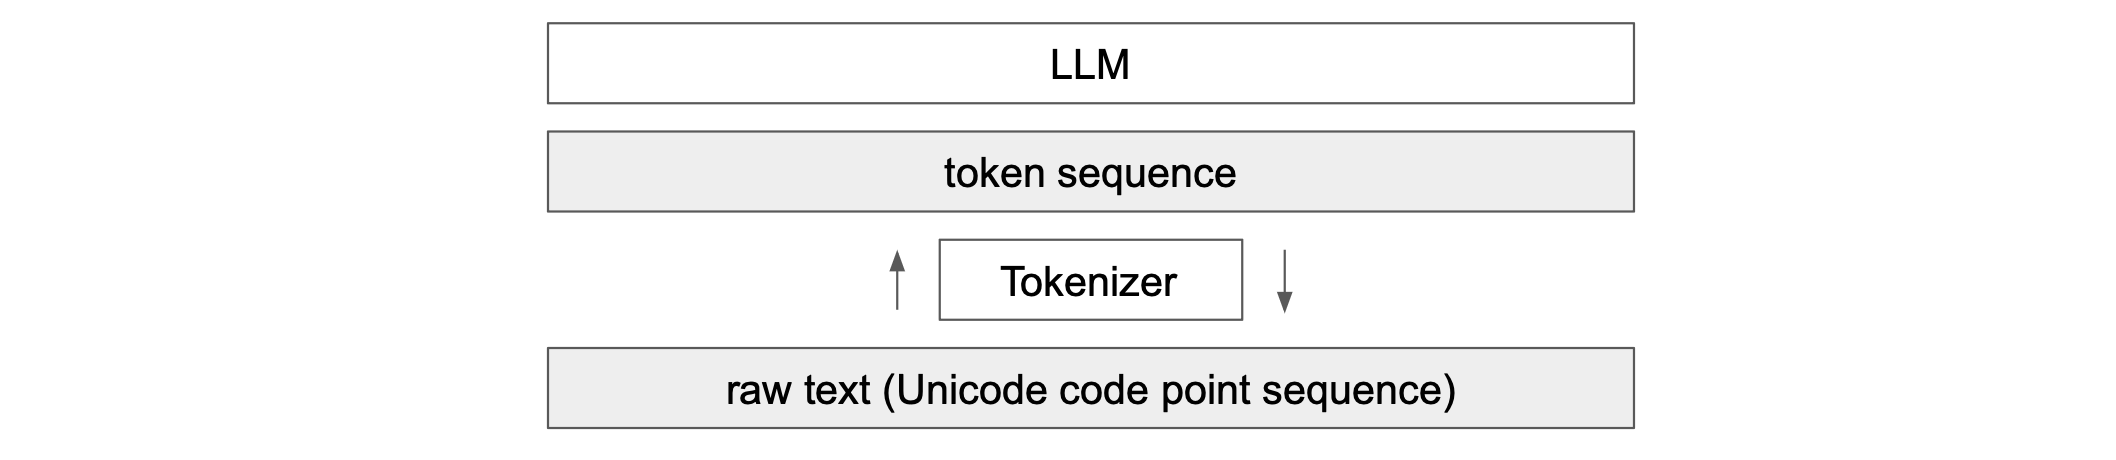

- notice that tokenizers are a completely separate object from the LLM itself
    - everything in this lecture is not really touching the LLM iself
    - we are just training the tokenizer, which is a completely separate preprcessing stage usually
        - so, the tokenizer will have its own training set, just like the LLM has a potentially different training set
        - we would run it a single time in the beginning, and once it is trained -the vocabulary is built and we have the merges-, we can do both encoding and decoding using it for any text (check the above image)
            - we use the trained tokenizer to encoder the raw text (in unicode code points then UTF-8 encodings) into the actual token sequence that we will feed into the LLM
            - we can then decode the output of the LLM (which will also be a token sequence) back into raw text (in unicode code points)
            - so the tokenizer once its trained, it acts as a translation layer between the raw text and the token sequence that the LLM can understand
            - and then the LLM will be trained as a step 2 afterwards


- typically in a state-of-the-art application, we might take all of the training data for the language model and run it through the tokenizer, and translate everything into a massive token sequence
    - then we can then throw away the raw text and just keep the token sequence (those are stored on disk, and that is what the LLM is actually reading when it is training on them)

- so all in all, this is a completely separate stage. it usually has its own entire training set, we may want to have those training sets be different between the tokenizer and the LLM
    - for example, when we train the tokenizer, we don't just care about the performance of english text, we care about many different languages and also code 
    - so we may look into different kinds of mixtures of different kinds of languages and code, because the amount of different language that we have in the tokenizer training set will determine the most common pairs and how many merges of it will be and therefore determines the density of which this type of data will be represented in the token space
        - so if we add some amount of data, like a ton of Japanese data in the tokenizer training set, then more japanese tokens will get merged (so the tokens will span multiple japanese characters) and therefore japanese will have shorter sequences (which means more information in the finite context length of the transformer)

### encoding-decoding using the tokenizer we trained
- now we have the vocabulary and the merges -they are necessary as they tell us what tokens the new tokens are subtituting for

In [29]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

- the rest we can use chr to decode

#### Decoding
- given a token sequence, let's decode it to get the raw text

##### My implementation

In [30]:
token_to_pair = {token:pair for pair,token in merges.items()}
token_to_pair

{256: (101, 32),
 257: (105, 110),
 258: (115, 32),
 259: (116, 104),
 260: (101, 114),
 261: (99, 111),
 262: (116, 32),
 263: (226, 128),
 264: (44, 32),
 265: (97, 110),
 266: (111, 114),
 267: (100, 32),
 268: (97, 114),
 269: (101, 110),
 270: (257, 103),
 271: (261, 100),
 272: (121, 32),
 273: (46, 32),
 274: (97, 108),
 275: (259, 256)}

In [31]:
def get_pair(token):
    result = []
    if token in token_to_pair:
        a,b = token_to_pair[token]
        result.extend(get_pair(a))
        result.extend(get_pair(b))
    else:
        result.append(token)
    return result

def my_decode(token_sequence):
    uncompressed_tokens = [] # mine: stores the utf-8 encodings -integer representation- 
    for token in token_sequence:
        if token in token_to_pair:
            uncompressed_tokens.extend(get_pair(token))
        else:
            uncompressed_tokens.append(token)

    return bytes(uncompressed_tokens).decode('utf-8') # converts to bytes and then decode to utf-8

decoded_text = my_decode(sequence) 

In [32]:
decoded_text == text

True

##### Karpathy's implementation

In [33]:
# get a vocabulary that stores the bytes representation of all 256 values
vocab = {idx:bytes([idx]) for idx in range(256)}

for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1] # for the merged tokens index store their merged bytes representation

vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

- notice that we don't need recursion as the compounded tokens (when a pair is merged then their result is merged again) already expressed in srings (since we looped on merged in order), so each compounded token has already all its children defined in the vocabulary
- notice the b before the strings, indicating that these are bytes

In [34]:
# then we just loop on the tokens sequence and index the vocab to get the corresponding string
def decode(tokens_sequence):
    # call the vocab on all indices to get the bytes representation of all utf-8 encodings
    tokens = b"".join(vocab[idx] for idx in tokens_sequence)
    text = tokens.decode('utf-8')
    return text

decoded_text = decode(sequence)
decoded_text == text

True

- notice that we put b before the string, to indicate that this is a byte string (in my implementation, i converted it to bytes then decoded it)
    - but here we already had the vocabulary as bytes, so we just put b before the string to indicate that it is a byte string, then decode it

- both implementations above have an issue, and it has something to do with utf-8 decoding
    - try decoding something with 128, it will throw an error
     

In [35]:
decode([128,153])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
decode([226, 128,153])

'’'

- 128 refers to the byte 0x80, which is ivalid start byte
- what does this mean?
    - we said that there is a specific encoding schema for utf-8
    - one of the rules is that they have to have a specific prefix 

        ![image.png](assets/utf_8_encoding.png)
        - all starting bytes can either be 0xxxxxxx or 110xxxxx or 1110xxxx or 11110xxx
    - but 128 is 10000000, which is not a valid byte in utf-8
- the way to fix this is in the decode function there is a parameter called `errors`
    - it is set to `strict` by default, which means that if it sees an invalid byte, it will throw an error
    - but there are several options, one of them is `replace`, which will replace the invalid byte with a special character (�) called the replacement character

In [36]:
# then we just loop on the tokens sequence and index the vocab to get the corresponding string
def decode(tokens_sequence):
    tokens = b"".join(vocab[idx] for idx in tokens_sequence)
    text = tokens.decode('utf-8',errors='replace')
    return text

decode([128])

'�'

In [37]:
def my_decode(token_sequence):
    uncompressed_tokens = [] # mine: stores the utf-8 encodings -integer representation- 
    for token in token_sequence:
        if token in token_to_pair:
            uncompressed_tokens.extend(get_pair(token))
        else:
            uncompressed_tokens.append(token)

    return bytes(uncompressed_tokens).decode('utf-8',errors='replace') # converts to bytes and then decode to utf-8

my_decode([128]) 

'�'

- so not every byte sequence is a valid utf-8 sequence, and if it happens that the large language model for example predicts the tokens in a bad manner, they might not fall into a valid utf-8, therefore we won't be able to decode them
    - so the standard practice is to use `replace`, which we can also find in openAi code that they released
    - so whenever we see that character in the output, we know that something went wrong and the LLM output is not valid sequence of tokens (valid utf-8)
        - mine: notice that the output of the LLM is compressed utf-8 using byte pair encoding, so we decompress it to get the utf-8, then we decode it to get the string

#### Encoding

- the other way around, given UTF-8 encodings,  encode it to get the token sequence (mine: compressed utf-8)

In [38]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

In [39]:
def encode(text):
    # first convert the text to utf-8 encodings in integer representation
    tokens = list(text.encode('utf-8'))
    while True:
        # use get stats to get all pairs 
        stats = get_stats(tokens)
        # get the most eligible pair 
        pair = min(stats, key=lambda x: merges.get(x, float("inf"))) # get the id from the merges dict if it exists, inf if they are not in merges, then get the minimum id (should be merged first)
        # notice that in the end all of them will have inf -not mergable- and min will get one of them
        if pair not in merges:
            break # nothing else can be merged
        idx = merges[pair]
        tokens = merge(tokens, pair, idx)
    return tokens

encode("hello world!")

[104, 101, 108, 108, 111, 32, 119, 266, 108, 100, 33]

- we first conver the text to byte integers 
    - now some of them are merged, even multiple times
    - so, we would like to do all these merges in the beginning before the later merges (because a later merge might depend on a previous merge)
        - so we call get_stats to get all the pairs in the tokens (we don't care about their counts, we just care about the pairs themselves), this gets us the possible merge candidates
        - now we want the pairs that exist in merges, and we want the minimum (so that we merge in order as we said)
            - the way to do this is by calling min on the stats pairs -all possible pairs-, we use key to decide the values to compare by in order to get the minimum
            - inside it we make a call to merges, if this pair in merges then get its id (notice that beginning pairs have ids smaller than the later pairs), otherwise if it is not in merges then assign it a value infinity

- however we may pass a single character, so there are no pairs and the function will throw an error

In [40]:
encode("a")

ValueError: min() arg is an empty sequence

In [41]:
def encode(text):
    # first convert the text to the list of byte integers
    tokens = list(text.encode('utf-8'))
    while len(tokens) >= 2:
        # use get stats to get all pairs 
        stats = get_stats(tokens)
        # get the most eligible pair 
        pair = min(stats, key=lambda x: merges.get(x, float("inf")))
        # notice that in the end all of them will have inf -not mergable- and min will get one of them
        if pair not in merges:
            break # nothing else can be merged
        idx = merges[pair]
        tokens = merge(tokens, pair, idx)
    return tokens

encode("a")

[97]

#### Making sure it works

- if we take a string, encode it then decode it back, we expect to get the same string back
    - I think in general this is the case

- but notice that going backwards, not all token sequences are valid utf-8 byte streams

In [42]:
print(decode(encode("hello world")))

hello world


In [43]:
text2 = decode(encode(text))
text2 == text

True

In [44]:
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


- it also works with text it has not seen -been trained on-
- this gives us some confidence that it is correctly implemented

- that was the basics of the byte pair encoding algorithm
    - we saw how we can take some training set and train the tokenizer on them (build the tokenizer from them)
        - the parameters of the tokenizer really are just the dictionary of merges
    - once we have it, we can encode and decode between text and token sequences
        - mine so we have text -(utf-8 encode)> utf-8 -(encode using the vocabulary)-> token sequence that we feed into the LLM and get out of the LLM ,wich is compressed utf-8 -(decode using the vocabulary)-> utf-8 -(utf-8 decode)> text 


![byte pair encoding](assets/byte_pair_encoding.png)

- mine: notice that the LLM can be evaluated on any text in the world (since we work on UTF-8 encodings which can encode any text in the world, and what BPE does is just compressing common sequences of utf-8 bytes in extra tokens)
    - Byte Pair Encoding (BPE) is a practical middle ground between character and word level language modeling which effectively interpolates between word level inputs for frequent symbol sequences and character level inputs for infrequent symbol sequences
    - This input representation allows us to combine the empirical
    benefits of word-level LMs with the generality of byte-level
    approaches. Since our approach can assign a probability to
    any Unicode string, this allows us to evaluate our LMs on
    any dataset regardless of pre-processing, tokenization, or
    vocab size

- now we will look at some of the state-of-the-art LLMs and their tokenizers
    - we will see that the picture complexifies very quickly
    - and we will go through the details of this complexification

## State-of-the-art LLMs' tokenizers

### (GPT series)

#### Forced Splits using Regex patterns 

- they didn't apply PBE naively as we did
    - suppose we have common words like dog, it occurs frequently in the text right next to all kinds of punctuations as an example
        - dog., dog!, dog?, and so on
    - and naively applying BPE, we would have tokens for each of these
        - so we would have dog. token and dog! token and dog? token and so on
        - so we are wasting a lot of tokens on common words variations, not only that but we are combining semantics with punctuation -so we are clustering things that shouldn't be clustered- (like we are saying the same semantics but with different punctuations are different tokens)
            - this is suboptimal
        - so we want to top down in a manual way to force that some types of character categories should never be merged together
            - so we want to enforce some merging rules on top of the BPE algorithm

In [5]:
import regex as re
gpt2pattern = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pattern, "Hello world123 how are you? I'm fine??!!!"))

['Hello', ' world', '123', ' how', ' are', ' you', '?', ' I', "'m", ' fine', '??!!!']


- they used the regex library
    - re.compile is a function that takes a regex pattern and compiles it into a regex object
    - then we can use this object to match the pattern in the text
        - like in re.findall, we pass the regex object and the text, and it will return all the matches of the pattern in the text, organizes them in a list

    - when we look at the pattern itself
        - r"""""" is a raw string, which means that we don't want to interpret any of the backslashes in the string as escape characters
        - it is made up of alot of ORs (the vertical bars `|`), which means that we are looking for any of these patterns
        - the patterns themselves are
            - 's
                - this is a common contraction in english, like it is, it's
            - 't
                - another common contraction in english, like do not, don't
            - 're
                - another common contraction in english, like they are, they're
            - 've
                - another common contraction in english, like have, they've
            - 'm
                - another common contraction in english, like I am, I'm
            - 'll
                - another common contraction in english, like will, I'll
            - 'd
                - another common contraction in english, like would, I'd
            - ` ?\p{L}+`
                - space+? means an optional space, then \p{L} means any letter in any language, then + means one or more of these letters
                - mine: so i think this matches any word in any language proceeded by a space or not -and if proceeded by a space it will be included in the match-
            - ` ?\p{N}+`
                - space+? means an optional space, then \p{N} means any number, then + means one or more of these numbers
                - mine: so this extracts any number proceeded by a space or not -and if proceeded by a space it will be included in the match-
            - ` ?[^\s\p{L}\p{N}]+`
                - this is saying optional space, followed by something that is not a space, not a letter, and not a number (one or more of it)
                    - in more details [^...] is called the negated character class, it matches anything that is not in the class (not inside it)
                    - so, basically this is trying to match any punctuation
            - `\s+(?!\S)`
                - this matches any whitespace that is not followed by a non-whitespace character
                - in details, \s+ matches one or more whitespace characters, then (?!\S) is a negative lookahead -general form is (?!...) which says that the next character should not be whatever is inside it- and inside it is \S which means any non-whitespace character (mine: \S is with capital S, which means non-whitespace, unlike \s which is whitespace)
                - so this is basically matching any whitespace up to -but not including- the last whitespace character
                - why is this important?
                    - see how white spaces are always included at the beginning of each pattern (at the beginning of words, numbers, and punctuations)
                    - so they did that so that the last space can join whatever is after it (say a word or a number)
                - so any extra white space will be caught by this pattern, and we leave one white space to be included at the beginning of the next pattern
                - so notice how gpt-2 likes to prepend a space to different patterns (they say that it significantly improves the compression efficiency)

            - `\s+`
                - this is just matching one or more white spaces
                - so this catches any trailing spaces or newline characters
                - mine: this is in case we matches everything and there is a trailing space at the end

            - mine: notice that the order of these patterns matter, we are doing an OR so the engine will try to match with any of the patterns from left to right and as soon as it finds a match it will stop and not consider the remaining alternative patterns
                


- some mistakes they made in the regex patterns
    - they only included this apostrophe ', and not this one ’
        - so they missed some contractions
    - they made the apostrophe splits according to the english language, -so it is language specific-
        - so if we have apostrophes in other languages, they will also be split 
    - they should have added re.IGNORECASE to the re.compile, so that it matches the patterns regardless of the case
        - for example if we have a text I'm, it will match the pattern 'm, but if we have I'M, it won't match the pattern 'm

- why we are doing this? we will take our string, and instead of directly encoding it for tokenization, we will first split it up using the above patterns, then we take the elements of the list and process them independently by the tokenizer, and then all of the results are concatenated
    - so we are only considering merges for each element in the list individually (that way we can never merge multiple elements we specifically split above)
    - then after we done all the possible merging, we concatenate the results
    - that is how we ensure the splits that we want to enforce (we will never be considering merges for multiple elements in the list, so whatever we split by force will never be merged together)
        - so basically using the regex patterns to chunk up the text is just one way of enforcing that some merges not to happen
    - mine: so in the above regex, we ensure that words, numbers, punctuations, extra spaces, are all split up into different elements therefore won't be merged together by the tokenizer (the tokenizer will only consider merges for each one of them individually)




In [58]:
example = """
for i in range( 1, 101 ):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pattern, example))

['\n', 'for', ' i', ' in', ' range', '(', ' 1', ',', ' 101', ' ):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


- mine: notice that \n and for in the line after it were not in the same element. because we \n is a type of whitespace, but not a space which we specifically mention before each pattern (like words, numbers and punctuations)
    - so \n will be caught by `\s` but not ` ?`

- so notice that we are splitting every time a category changes, therefore will never be any merges between different categories

- we might think that in order to train the tokenizer, openAi has used this to split up text then run PBE withen the chunks, but that is not exactly what happened (notice how extra spaces are grouped into 1 element by the regex, but then they never actually were merged as we saw in the beggining of this notebook) mine: which indicates that the vocabulary doesn't have merges for extra spaces
    - the training process of the tokenizer was never released, they just released the inference code, which takes the merges and applies them (not the code that trained the tokenizer)
    - so whatever it was, it wasn't as simple as chunk it up then run BPE on the individual chunks to build the tokenizer (we don't know how they trained the tokenizer)

#### Tiktoken

- as we said, this is the official tokenizer for the GPT series

- we can use it (use their trained tokenizers) to encode and decode text (do inference)

In [66]:
enc = tiktoken.get_encoding('gpt2')
# GPT-2 (doesn' merge spaces)
print(enc.encode("    hello world!!!  "))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding('cl100k_base')
print(enc.encode("    hello world!!!   "))

[220, 220, 220, 23748, 995, 10185, 220, 220]
[262, 24748, 1917, 12340, 262]


- so what changed in the GPT-4 tokenizer?
    - they changed the regular expression that they use to chunk up text
    - they changed the regex pattern from what we saw above to a new one
        - that was the major change in addition to a bunch of other special tokens
        - they solved the case sensitivity issue regarding the apostrophes (which we talked about)
        - they handled white spaces in different ways
        - when they matched the numbers, they didn't match it fully as above, but up to 3 digits (which means they will never merge numbers that are more than 3 digits)
            - in other words, there will never be a token that represents a number that is more than 3 digits
            - they did so to prevent tokens that are very long number sequences
            - we don't really know why they do any of this stuff, as none of this is documented
    - the vocabulary size went from 50k to 100k

#### GPT-2 encoder.py

- let's go through the code of GPT-2 encoder.py (the code that encodes text into token sequences)
- Reference the GPT-2 [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
Download the vocab.bpe and encoder.json files.
    - they are loading 2 files, encoder.json and vocab.bpe
        - these 2 files together constitute their saved tokenizer

In [69]:
import os, json

with open('encoder.json', 'r') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab" which stored the bytes representation of the tokens

with open('vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges"

- so they are saving and loading the 2 variables vocab and merges
- using them we can do both encoding and decoding

- they have something called byte_encoder() and byte_decoder() -in addition to encoder() and decoder()
    - this is unfortunately a spirous implementation detail, so we will skip it

- long story short, it is a messy code that they have, but algorithmically identical to what we have built

#### Special tokens

- in addition to the tokens that are coming from raw bytes and BPE merges, we can insert all kinds of tokens that we are going to use to
    - delimite different parts of the data
    - introduce to create a special structure of the token streams


In [73]:
encoder

{'0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '10': 940,
 '11': 1157,
 '12': 1065,
 '13': 1485,
 '14': 1415,
 '15': 1314,
 '16': 1433,
 '17': 1558,
 '18': 1507,
 '19': 1129,
 '20': 1238,
 '21': 2481,
 '22': 1828,
 '23': 1954,
 '24': 1731,
 '25': 1495,
 '26': 2075,
 '27': 1983,
 '28': 2078,
 '29': 1959,
 '30': 1270,
 '31': 3132,
 '32': 2624,
 '33': 2091,
 '34': 2682,
 '35': 2327,
 '36': 2623,
 '37': 2718,
 '38': 2548,
 '39': 2670,
 '40': 1821,
 '41': 3901,
 '42': 3682,
 '43': 3559,
 '44': 2598,
 '45': 2231,
 '46': 3510,
 '47': 2857,
 '48': 2780,
 '49': 2920,
 '50': 1120,
 '51': 4349,
 '52': 4309,
 '53': 4310,
 '54': 4051,
 '55': 2816,
 '56': 3980,
 '57': 3553,
 '58': 3365,
 '59': 3270,
 '60': 1899,
 '61': 5333,
 '62': 5237,
 '63': 5066,
 '64': 2414,
 '65': 2996,
 '66': 2791,
 '67': 3134,
 '68': 3104,
 '69': 3388,
 '70': 2154,
 '71': 4869,
 '72': 4761,
 '73': 4790,
 '74': 4524,
 '75': 2425,
 '76': 4304,
 '77': 3324,
 '78': 3695,
 '79

In [74]:
len(encoder) # 256 raw byte tokens + 50k merged tokens (they did 50k merges) + 1 special token

50257

In [75]:
encoder['<|endoftext|>']

50256

- that is a special token (the last token), and it is used to delimite documents in the training set (to denote that the document has ended)
    - so when we are creating the training data (mine: the LLM training set), we have all these documents, and we tokenize them and get a stream of tokens
        - those tokens only range from 0 to 50256 
    - then in between those documents, we put a special `<|endoftext|>` token 
        - we use this as a singnal to the language model, that the document has ended, and that what follows is unrelated to the document
        - and the language model has to learn that from data, it needs to learn that this token usually means that it should wipe its memory of what came before (that what came before is not informative of what comes next)

    - so, this token didn't actually go through the PBE algorithm
        - we have special case handling for these special tokens, like registering them, add to the vocabulary, encode them (we look for them specifically in the text and replace them with their token id), 

- these special tokens are used pervasively, not just in base language models, but especially later in the fine tuning stage, we don't just want to delimite documents, but we want to delimite entire conversations between an assistant and a user 

- the default example in the tiktoken page is using not base model encoders, but fine-tuned model tokenizers

![tok example 4](assets/tok_example_4.png)

- notice the special tokens
    - i am start "imaginary monologue start"
    - i am end
    - etc.

- so we have a start and end of every single message, and alot of other special tokens to delimit these conversations and keep track of the flow of the messages here

- we can actually extend tiktoken and create additional special tokens with new ids, and the library will swap them out when it sees them in the strings

- in GPT-2 tokenizer, we have end of text token, and in GPT-4 tokenizer, we have also end of text and 
    - FIM_prefix
    - FIM_middle
    - FIM_suffix
        - to learn more about them check the paper [efficient training of large language models to fill in the middle](https://arxiv.org/pdf/2207.14255) 
    - end of prompt


- so, it is very common to train a language model, and add special tokens
    - when we add special tokens, we have to do some model surgery to the transformer and all the parameters involved, as we are basically adding an integer
        - so we want to make sure that the embedding matrix for the vocabulary has to be extended for them (these additional rows will be initialized with small random numbers or something like that)
        - we also have to go to the final layer of the transformer and make sure that the final layer which projects to vocab_size is extended as well
    - this is a very common operation that people do, especially if they like to fine-tune the model (taking it from a base model to a chat model)


#### minbpe exercise


At this point you have everything you need to build your own GPT-4 tokenizer. This is the [exercise progression](https://github.com/karpathy/minbpe/blob/master/exercise.md) you may wish to follow. You'll note that it is part of the [minbpe](https://github.com/karpathy/minbpe) repo, which is the solution to that exercise, and is a cleaned up version of the code above.


- mine: i implemented both the basic tokenizer (which is implemented here) and Regex tokenizer 

- for the regex tokenizer
    - we use the regex specified to split the text into chunks of different categories (words, numbers, punctuations, extra spaces)
    - then we train the tokenizer on them
        - we get the common pair in all the text chunks (but since we separated them we have no pairs of an element end with another element beggining)
        - so we have no pairs that span multiple categories
        - then we get the top pair in all text chunks 
        - then we merge that pair in all text chunks
    - then we encode 
        - we split the text into chunks using the regex of different categories
        - then we call encode on each chunk individually and concatenate the result tokens
    - in decode 
        - fairly the same as the basic token, nothing changes

- as for handling the special tokens
    - we do that manually 
    - we first register the tokens using a function called register_special_tokens
        - now they will be stored separately in a dictionary with special tokens as keys and their ids as values
    - in the encode
        - we also encode them manually by specifying the special tokens as regex patterns
        - then separating the text whenever we encounter a special token 
        - now we have multiple text elements, some are special tokens and some are ordinary text
        - for each text element if it is a special token we encode it using the special tokens dictionary, otherwise -normal text- we encode it using the ordinary encoder (which further splits the normal text into chunks of different categories then encodes them)
    - in the decode
        - for each token, we will either find it in the inverse of the special tokens dictionary (if it is a special token) or we will find it in the vocabulary (if it is a normal token)

- so, we can say that we added 2 layers over the tokenizer we implemented in here
    - the first layer concerns the normal text, as we use a regex to split different categories of text, then we train, encode and decode on these separate elements
        - that way we will have no pair spanning multiple elements therefore no tokens spanning multiple categories
    - the second layer is a special token handler, where we manually register special tokens in a separate dictionary, and we look for these special tokens in the text and manually replacing them with their ids before encoding the rest of the text, and in the decode we also check if the token exists in that separate dictionary and replace it with the special token
    - there are even a lot of options in the encoder function (whether to allow all special tokens or some of them of none of them at all)
    - so i think that we can train the text normally, then add the special tokens later for the encoding and decoding depending on our application, I still need to know whether we add the special tokens in the tokenizer training set or not (but so far it seems that we add them later)

In [43]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the GPT-4 tokenizer
text = """
for i in range( 1, 101 ):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
    <|endoftext|>"""
enc.encode(text, allowed_special="all")

[198,
 2000,
 602,
 304,
 2134,
 7,
 220,
 16,
 11,
 220,
 4645,
 21711,
 262,
 422,
 602,
 1034,
 220,
 18,
 624,
 220,
 15,
 323,
 602,
 1034,
 220,
 20,
 624,
 220,
 15,
 512,
 286,
 1194,
 446,
 99615,
 60573,
 1158,
 262,
 4508,
 602,
 1034,
 220,
 18,
 624,
 220,
 15,
 512,
 286,
 1194,
 446,
 99615,
 1158,
 262,
 4508,
 602,
 1034,
 220,
 20,
 624,
 220,
 15,
 512,
 286,
 1194,
 446,
 60573,
 1158,
 262,
 775,
 512,
 286,
 1194,
 1998,
 340,
 257,
 100257]

In [44]:
from minBPE import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load('minBPE\python_trained_models\python_regex_tokenizer.model')
tokenizer.encode(text, allowed_special="all")

[10,
 102,
 111,
 114,
 258,
 286,
 290,
 40,
 32,
 49,
 44,
 32,
 292,
 294,
 257,
 295,
 258,
 261,
 32,
 51,
 263,
 32,
 48,
 32,
 276,
 100,
 258,
 261,
 32,
 53,
 263,
 32,
 48,
 259,
 264,
 269,
 272,
 278,
 280,
 273,
 257,
 282,
 258,
 261,
 32,
 51,
 263,
 32,
 48,
 259,
 264,
 269,
 272,
 278,
 273,
 257,
 282,
 258,
 261,
 32,
 53,
 263,
 32,
 48,
 259,
 264,
 269,
 272,
 280,
 273,
 257,
 275,
 115,
 101,
 259,
 264,
 269,
 40,
 105,
 271,
 260,
 296]

In [45]:
tokenizer.vocab, tokenizer.special_tokens

({0: b'\x00',
  1: b'\x01',
  2: b'\x02',
  3: b'\x03',
  4: b'\x04',
  5: b'\x05',
  6: b'\x06',
  7: b'\x07',
  8: b'\x08',
  9: b'\t',
  10: b'\n',
  11: b'\x0b',
  12: b'\x0c',
  13: b'\r',
  14: b'\x0e',
  15: b'\x0f',
  16: b'\x10',
  17: b'\x11',
  18: b'\x12',
  19: b'\x13',
  20: b'\x14',
  21: b'\x15',
  22: b'\x16',
  23: b'\x17',
  24: b'\x18',
  25: b'\x19',
  26: b'\x1a',
  27: b'\x1b',
  28: b'\x1c',
  29: b'\x1d',
  30: b'\x1e',
  31: b'\x1f',
  32: b' ',
  33: b'!',
  34: b'"',
  35: b'#',
  36: b'$',
  37: b'%',
  38: b'&',
  39: b"'",
  40: b'(',
  41: b')',
  42: b'*',
  43: b'+',
  44: b',',
  45: b'-',
  46: b'.',
  47: b'/',
  48: b'0',
  49: b'1',
  50: b'2',
  51: b'3',
  52: b'4',
  53: b'5',
  54: b'6',
  55: b'7',
  56: b'8',
  57: b'9',
  58: b':',
  59: b';',
  60: b'<',
  61: b'=',
  62: b'>',
  63: b'?',
  64: b'@',
  65: b'A',
  66: b'B',
  67: b'C',
  68: b'D',
  69: b'E',
  70: b'F',
  71: b'G',
  72: b'H',
  73: b'I',
  74: b'J',
  75: b'K',
  76: b'

- so now we do the same behavious as tiktoken, but in addition we provide a train function (they only provide encode/decode)

- and the difference between our tokenizer and GPT-4 tokenizer is only a difference of the training set

### Sentence Piece Library intro

- we are now going to move away from tiktoken and the way OpenAI tokenizes its strings
- now we will discuss one more very commonly used library for working with LLMs tokenizers, which is `Sentence Piece`
- `SentencePiece` is very commonly used in language models, because unlike tiktoken, it can do both training and inference (encode/decode), and it is quite efficient at both
- it supports a number of algorithms for training vocabularies, one of them is the BPE algorithm we have been looking at
- is is used both by LLama and Misteral series, and many other models
- it is on [github](https://github.com/google/sentencepiece)

- the big difference with sentence piece (and we look at example), is that they have a different order of operations
    - in tiktoken, code points -> utf-8 encodings -apply BPE on utf-8 encodings-> token sequence
    - in sentence piece, they work direcly on the the codepoints themselves!
        - so code points -apply BPE on code points-> token sequence
    - if we happen to run out of code points, like some rare code points that just don't come up often, and the rarity is determined by the `character_coverage` hyper parameter, then these code points will be mapped to `<unk>` token or if we have `byte_fallback` set to true, then they will be mapped to utf-8 encodings, then the individual bytes will be translated to tokens (special byte tokens that get added to the vocabulary)
    - so it uses PBE on code points, and falls back to bytes for rare codepoints

In [46]:
import sentencepiece as spm

In [47]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

- what is crazy about sentencePiece is that they have a ton of options and configurations
- the reason for that is because it has been around for a while, and it tries to handle a large diversity of things

In [48]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

- we tried to setup sentence piece in a way that is very similar to LLama 2 tokenizer
    - we took the tokenizer.model file that meta released and inspected all the options 

- normalization used to be very prevelent (normalization rules like lowercasing, removing accents, etc.), mine: standardization
    - in LLMs we don't prefer to do any of it, because we want to not touch the data and keep them in the raw form as much as possible

- sentencepiece was probably developed early in the days when there was an idea of training the tokenizer on a bunch of independent sentences, 
    - so it has hyperparameters like
        - input sentence length (maximum number of training sentences)
        - max sentence length (maximum bytes per sentence)
        - shiffle input sentence
    - so for it sentences are like the individual training examples
    - but in the context of LLMs this is very weird and sperious, it is really hard to define what a sentence is, just treat the file as a giant steam of text 

- it has a lot of treatment about rare words (code points)

- it has a lot of rules for splitting digits, whitespace, numbers (merge rules)
    - equivalent to tiktoken using regex to split up categories

- they also have special tokens
    - they hardcode the 
        - unk token 0 (must exist)
        - beginning of sentence token 1
        - end of sentence token 2
        - pad token 3

In [49]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

- we see the 256 byte tokens (because we turned on byte_fallback to true), then we see the merges (we see the parent token not the token pair that was merged to get it), then after the merges comes the individual tokens and their ids (individual code point tokens)
    - so we have
    - special tokens
    - byte tokens
    - merge tokens (of the code points it encountered in the training set)
    - individual code point tokens (that it encountered in the training set)

- the tokens that are extremely rare (determined by character_coverage, which is currently set to 0.99995), so if a code point occurred a single time out of like a million code points, it will be mapped to the unk token (won't be added to the individual code points)

- mine: i think when we encounter a code point that is not in the merge tokens or individual code point tokens, it will be mapped to the unk token, or encoded to utf-8 then use the byte tokens to encode it (if we turn on byte_fallback)

In [53]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


In [54]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


- notice that the korean letters, since they were not part of the training set
    - so sentencepiece is encountering code points it has not seen during training 
    - and so they don't have a token associated with them (mine: not in the merge tokens or individual code point tokens)
    - so suddenly these are unk tokens, but because we set byte_fallback to true, the vocabulary contains tokens for each byte, and so these letters are encoded as bytes using utf-8, then encode the bytes

- notice that we also have extra space before hello, where is this coming from?
    - it came from add_dummy_prefix = True, which adds a dummy space in the beginning of the text in order to treat world in "world" and "hello world" as the same token
    - so they want to unify them as a single token
    - in tiktoken and openAI, a word might be a different token than  space+word, and the LLM has to learn from data that they are actually very similar concept (it has to learn that it is the same word but one at the beginning of the sentence and the other is at the middle of it)
    
    ![tiktoken space](assets/tiktoken_space.png)

- let's remove byte_fallback

In [55]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995, # the percentage of characters covered by the model
  byte_fallback=False,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

In [56]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['en', 3],
 ['▁t', 4],
 ['ce', 5],
 ['in', 6],
 ['ra', 7],
 ['▁a', 8],
 ['de', 9],
 ['er', 10],
 ['▁s', 11],
 ['ent', 12],
 ['or', 13],
 ['pr', 14],
 ['▁m', 15],
 ['▁u', 16],
 ['ing', 17],
 ['▁th', 18],
 ['ence', 19],
 ['entence', 20],
 ['Pi', 21],
 ['ed', 22],
 ['em', 23],
 ['ex', 24],
 ['is', 25],
 ['iz', 26],
 ['la', 27],
 ['on', 28],
 ['st', 29],
 ['▁S', 30],
 ['Pie', 31],
 ['end', 32],
 ['ext', 33],
 ['▁an', 34],
 ['▁pr', 35],
 ['▁to', 36],
 ['▁un', 37],
 ['▁the', 38],
 ['Piece', 39],
 ['▁Sentence', 40],
 ['▁SentencePiece', 41],
 ['.]', 42],
 ['Ne', 43],
 ['ag', 44],
 ['do', 45],
 ['ec', 46],
 ['gu', 47],
 ['ic', 48],
 ['ir', 49],
 ['it', 50],
 ['ly', 51],
 ['to', 52],
 ['▁(', 53],
 ['▁[', 54],
 ['▁f', 55],
 ['▁n', 56],
 ['▁w', 57],
 ['.])', 58],
 ['age', 59],
 ['del', 60],
 ['ion', 61],
 ['ken', 62],
 ['lan', 63],
 ['ral', 64],
 ['wor', 65],
 ['yst', 66],
 ['▁Ne', 67],
 ['▁al', 68],
 ['▁de', 69],
 ['▁is', 70],
 ['▁ma', 71],
 ['▁mo', 72],

- all the byte tokens disappeared, and have a lot more merges now (since we have a lot more slots in the vocabulary)
    

In [57]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 252, 102, 362, 0]


In [58]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'el', 'lo', '▁', '<unk>']


- the entire korean string is unk
- so keep in mind that this would feed into the language model, and imagine what happens when all unrecognized characters just because they are rare will mapped to unk (disaster)
- so we have to use byte_fallback because we want to be able to encode every string that we encounter, even if it is a rare string

- this is the raw protocol buffer representation of the tokenizer that LLama 2 trained
    - if we want our tokenization to look like that of LLama 2 

**Llama 2 tokenizer proto**
If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```

- our summary for sentence piece
    - there is a lot of historical baggage in the library, and it has a lot of options and concepts that are slightly confusing 
    - otherwise it is fairly commonly used in the industry because it be both trained and used for inference
    - it has few quirks (weird things you have to be aware of), like the byte fallback, and the normalization rules, and the way it treats sentences
    - it is not very well documented
        - so we have to visualize things and try to understand what is happening here

## Some Aspects and Notes

### how to set vocabulary set? revisiting gpt.py transformer

- how to set the vocabulary size? and what are some of the considerations around it?

- for this we will go back to the architecture we implemented `gpt.py` in the last notebook
    - in there, it was a character level, and only supporting the characters appearing in the tinyshakespeare file

- first, what does vocab_size affect in the architecture?

    ![vocab_size_in_our_gpt](assets/vocab_size_in_our_gpt.png)

    1. the embedding table of the tokens (specifically the number of rows)
        - so as the vocabulary size increases, this table will grow (we will be adding rows) 
    2. at the end of the transformer (the language model head), which is a linear layer that produces the logits (which becomes the probabiilities for the next tokens in the sequence)
        - so every single token will produce an additional dot product in the linear layer 

- so, why can't vocab size be infinie? 
    1. your token embedding table will grow (more parameters)
        - so we could be worried that we are going to be under-training some of them
        - intuitevly, if we have extremely large vocabulary size (say million tokens), then everyone of them will come up more and more rarely in the training data (mine: as we are distinguishing them into more and more tokens)
        - and so we will be seeing fewer and fewer examples of each token, and the vectors associated with them might be under-trained (haven't seen enough examples to learn a good representation)
    2. your linear layer will grow (more parameters and computation)
    3. we said that we will attend to more text (as the token spans more characters), which is a good thing, but if we will attend to too much text, the model wouldn't have much time to think (we are squishing too much information into a single token)
        - and the forward pass will not be enough to process that information appropriately
        - mine: imagine if an entire python script is a single token :D it will be too much for the model to process many of these tokens

- so, the vocab_size is an empirical hyperparameter, and it seems like in the SOTA architectures today, this is usually in the high 10,000s or somewhere around the 100,000 today

### Training new tokens

- what if we want to take a pre-trained model (mine: that has a certain vocabulary) and we want to extend the vocab size?
    - this is very common, soemtimes when people fine-tune them, a lot more special tokens get introduced on top of the base model to maintain the metadata and the structure of the conversations and so on
    - we might want to throw in more special tokens for example for using a browser, or any other tool

- so, it is totally possile to add a token, all we have to do is to 
    - resize the embedding table (add more rows), initialize them from scratch
    - extend the weight insie the language model head (the final linear layer that maps to vocab size)
    - they can be done very easily (both are resizing operations)

- so it is very common to freeze the base model, then introduce the new parameters for the new tokens, then only train them to introduce the new tokens to the architecture
    - and so we can freeze arbitrary parts of the model, or train arbitrary parts of the model

- actually, there is an entire design space (worth a whole video) of applications in terms of introducing new tokens into the vocabulary, that go way beyound adding special tokens for special new functionality
    - one of them is a paper called [learning to compress promts with Gist tokens](https://arxiv.org/pdf/2304.08467)
    - the rough idea is that. suppose that you are using language models in a setting that requires very long prompts 
        - they slow everything down because we have to encode them then attend over them then decode them 
    - so in the paper, they introduce new tokens, and then train the model by distilaltion (mine: meaning that they train the model to predict the new tokens, and then they freeze the model and train the new tokens to predict the old tokens)
        - so  they are keeping the entire model frozen, and they are only training the representations of the new tokens (the embeddings)
        - and we are optimizing on the new tokens such that the behavior of the language model is identical to the model that has a very long prompt
        - so it is a compression technique of compressing that very long prompt into few new gist tokens
        - and at test time, we can discard that old prompt and swap in the new tokens (which are much shorter), and the model will behave as if it has seen the long prompt
        - the parameters that we are training are just the token embeddings

### Multimodal (image, video, audio) tokeniztion with vector quantization

- there is a lot of momentum recently in how we actually could construct transformers that simultaneously process not just text, but also images, videos, and audio (in how do we feed in these modalities into the transformer and potentially predict these modalities as well)
    

- do we have to change the architecture in some fundamental way? what a lot of people are starting to converge towards is that we are not changing the architecture, but we stick with the transformer, and just tokenize the input domains then call the day and pretend it's jsut text tokens and do everything else identical

- for example there is an early paper [Taming Transformers for High-Resolution Image Synthesis](https://arxiv.org/pdf/2012.09841), it has a nice graphic for how to take an image and chunkate it into integers (these will basically become the tokens of images)
    - these tokens can be hard tokens (force them to be integers)
    - or soft tokens, where they are required to be discrete, but force them to go through bottlenecks (like in autoencoders) 

- anther paper came out from openAI [SORA](https://openai.com/index/sora/), they talk breifly about how LLMs have text tokens, SORA has visual patches
    - so they came up with a way to chuncate vidoes into tokens with their own vocabularies
    - and then we can either process discrete tokens say with auto-regressive models, or even soft tokens with diffusion models
    - all of that is being actively worked on and designed on, and it is beyond the scope of this video

## Revisiting and explaining the quirks of LLM tokenization

- now that we got into the tokenization algorithm and we understand now a lot about how it works, let's loop back around to the beginning of this notebook and go through some of these bullet points, and see why they happen

- Why we need good tokenization? 
    - why can't LLM spell words? `Tokenization`
        - because of a very long tokens (if a token contains too many characters, the LLM understands it as a single entity), 

        ![very long token](assets/very_long_token.png)
        
        - so there is too much crammed into the single token, and the model should not be very good at tasks related to spelling of this token
        
        ![spelling quirk](assets/spelling_quirk.png)
        because this is what the model sees
        
        ![spelling quirk](assets/spelling_quirk_tokens.png)

    - why can't LLM do super simple string processing tasks like reversing a string? `Tokenization`
        - for the same reason
        
        ![reverse the string quirk](assets/reverse_string_quirk.png)

        - and to make sure that the reason for the above 2 points are actually due to tokenization, we asked them to list them letter by letter separated by spaces -now they are in multiple tokens- and then asked them again
        
        ![long tokens separated out](assets/long_tokens_separated_out.png)

        - when it lists them letter by letter, they separated into individual characters, and it is easier for it to process them
    - why is LLM worse at non-english languages? `Tokenization`
        - we talked about it above
    - why is LLM bad at simple arithmetic? `Tokenization`
        - that has to do with the tokenization of numbers, the algorithm for addition is character-level
        
        ![addition algorithm](assets/addition_algorithm.png)
        
        - we have to refer to the specific digits (we add the ones then the tens then the hundreds), but since these numbers are represented completely arbitrarily based on whatever happened in the PBE algorithm, the model unfortunately sometimes sees a token for all 4 digits, sometimes for 3 digits, sometimes for 2 or even 1, and it is all arbitrary
            - this is definitely headwind for the model to deal with it
        - there is an entire blog post about this [integer tokenization is insane](https://www.beren.io/2023-02-04-Integer-tokenization-is-insane/)
        - when meta trained the LLAama 2 algorithm using sentencepiece, they made sure to split up all the digits for llama 2 (to improve simple arithmetic)
         
    - why did GPT-2 have more than necessary trouble coding in python? `Tokenization`
        - we talked about it above, handling spaces in python is terrible
    - why did my LLM abrubtly halt when it sees the string `<endoftext>`? `Tokenization`
        
        - ![printing special tokens](assets/printing_special_token.png)
        
        - we don't know what they are doing under the hood, but they potentially parse this as an actual token instead of a string -individual pieces of it not a special token-
            - so it might be that when they call .encode, they are passing in the allowed_special, and they are allowing these tokens in the user prompt
            - but the user prompt is an attacker control text, so you would want not to parse these tokens in the user prompt
        - howerver, there is something wrong going wrong on here 
    - what is this weird warning i get about a "trailing whitespace"? `Tokenization`
        - if we used playgroun (which is something that chatGPT provide that is similar to base models) because the space characters are always a prefix to these tokens in GPT, but when we add a training space and encode, the space at the end becoems a token 220, this space was supposed to be a prefix to the next token, but now it is a token itself, and that gets us out of distribution (the model has seen very little data of actual spaces by itself, specially as a training whitespace)
    
    - back to the playground, which is something close to base models (document completer), we bet it has never seen .DefaultCellSty in its training set
        
        ![weird combination](assets/weird_combination.png)
        
        - the above combination is very very rare that the model has probably never seen in its training set, so what happens when we ask it to complete it?
        
        ![broken model](assets/broken_model.png)
        
        - the model immediately emitted the end of text token, and had no completion
        - again we are off the data distribution, and the model is predicting arbitrary things (it is confused)

    - so you can see these issues arise from us messing with its tokenization
        - we are completing things from its next token that it should predict (like trailing whitespace)
        - or removing some characters from long tokens (like .DefaultCellSty)
        - all of these are issues related to partial tokens
        - if we dig into the tiktoken repo, there is a lot of special case handling "unstable tokens" and it is not documented anywhere, but there is a ton of code dealing with unstable tokens
        - 
    - why the LLM break if I ask it about "SolidGoldMagikarp"? `Tokenization`
        - very famous [solid gold magikarp](https://www.alignmentforum.org/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation) 
        - what this person did, he went to the token embeddings table and clustered the tokens based on their embedding representation
        - he noticed that there is a cluster of tokens that look really starnge (like solidgoldmagikarp), so what are these tokens and where do they come from?
            - they noiced that if they asked the model about these tokens, then we get a variety of broken LLM behavior
        - this again comes down to tokenization, solidgoldmagikarp is a reddit user, and what is thought to have happened is that the tokenization dataset was very different from the LLM training dataset
            - so potentially, the tokenization dataset had a ton of reddit data, where the user SolidGoldMagikarp was mentioned in the text alot, and because it occurred a lot in the tokenization dataset, these tokens would end up getting merged into solidgoldmagikarp
                - so a dedicated token for solidgoldmagikarp in the 50k tokens in gpt2
            - then later when we train the model, this data from reddit was not present, and so in the entire training set never occurrs, therefore its embedding is still initialized at random 
            - and so at test time if we evoke this token again, we are basically blucking our a row that is completely untrained, and feeds to the transformer to create undefined behavior
    - why should I prefer to use YAML over JSON with LLMs? `Tokenization`
        - people noticed that different kinds of lnguages or formats are more or less efficient in GPT
        - just like how english is more efficient in GPT than other languages, some foramts like YAML are more efficient than JSON for the same reason (tokenizer training set)
        
        ![json_vs_yaml](assets/json_vs_yaml.png)
        
        - notice that the same information in both yaml and json, but they are encoded in few tokens in yaml (the token spans more characters), but in json they are encoded in more tokens (the token spans fewer characters)

    - why is LLM not actually end-to-end Language modeling? `Tokenization`
    - what is the real root of suffering? `Tokenization` :D


- so tokenization density is something that we have to care about and worry about all the time, and try to find efficient coding schemes, and spend alot of time in tiktokenizer and measure the different tokens' efficiencies, for all different formats and settings and so on


## Final recommendations

- Don't brush off tokenization. A lot of footguns and sharp edges here. Security issues. Safety issues.
- Eternal glory to anyone who can delete tokenization as a required step in LLMs.
- In your own application:
  - if you can reuse the GPT-4 tokens and the vocabulary, then that is something you should consider doing (using tiktoken)
  - but for some reason if you want to train your own tokenizer and vocabulary from scratch, then use PBE with sentencepiece
    - even though some things are hateful like the bytefallback and all the settings, which are very easy to miscalibrate them, ending up cropping your sentences 
    - so be very careful with the settings and try to copy paste exactly what meta did, and spend alot of time going with the hyper parameters 
    - however, the algorithm itself and the fact they are using PBE on code points is inferior to what openAI does
  - maybe the best thing is to wait for minPBE to become as efficient as sentencepiece (so that we can use something similar to tiktoken but with the ability to train the tokenizer)
    - currently minPBE is in python


## Also worth looking at

- [Huggingface Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer). I didn't cover it in detail in the lecture because the algorithm (to my knowledge) is very similar to sentencepiece, but worth potentially evaluating for use in practice.
